# MNIST Digit Recognition

From the paper.

### Dataset
Tutorial: https://pytorch.org/tutorials/beginner/nn_tutorial.html?highlight=mnist

### Model

**Architecture**

Our initial study includes three model families on two datasets. The first two are for the MNIST digit recognition task:
1) A simple multilayer-perceptron with 2-hidden layers with 200 units each using ReLu activations (199,210 total parameters), which we refer to as the MNIST 2NN.
2) A CNN with two 5x5 convolution layers (the first with 32 channels, the second with 64, each followed with 2x2 max pooling), a fully connected layer with 512 units and ReLu activation, and a final softmax output layer (1,663,370 total parameters).

**FL Setting**

We study two ways of partitioning the MNIST data over clients:
- IID, where the data is shuffled, and then partitioned into 100 clients each receiving 600 examples, and
- Non-IID, where we first sort the data by digit label, divide it into 200 shards of size 300, and assign each of 100 clients 2 shards.

### Conclusion

- With B = ∞ (for MNIST processing all 600 client examples as a single batch per round), there is only a small
advantage in increasing the client fraction.
- Using the smaller batch size B = 10 shows a significant improvement in using C ≥ 0.1, especially in the non-IID case.
- Based on these results, for most of the remainder of our experiments we fix C = 0.1, which strikes a good balance between computational efficiency and convergence rate.

In [ ]:
%matplotlib inline
import torch
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Step_00. load data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2)

testset = datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=2)

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

train_idcs, test_idcs = np.arange(len(trainset)), np.arange(len(testset)) # in case of validating set
train_labels = np.asarray(trainset.targets)


In [ ]:
# Step_01. iid VS non-iid
from data_utils import iid_partition, noniid_partition, CustomSubset

client_iid_idcs = iid_partition(train_idcs, train_labels)
client_iid_data = [CustomSubset(trainset, idcs) for idcs in client_iid_idcs]

client_noniid_idcs = noniid_partition(train_idcs, train_labels)
client_noniid_data = [CustomSubset(trainset, idcs) for idcs in client_noniid_idcs]

test_data = CustomSubset(testset, test_idcs, transforms.Compose([transforms.ToTensor()]))


In [ ]:
train_labels[client_iid_idcs].shape

(100, 600)

In [ ]:
train_labels[client_iid_idcs]

array([[1, 0, 1, ..., 7, 2, 7],
       [2, 3, 4, ..., 8, 8, 9],
       [0, 0, 9, ..., 5, 6, 8],
       ...,
       [5, 0, 4, ..., 8, 6, 1],
       [5, 8, 5, ..., 9, 3, 8],
       [9, 7, 3, ..., 0, 2, 7]])

In [ ]:
train_labels[client_noniid_idcs]

array([[6, 6, 6, ..., 3, 3, 3],
       [5, 5, 5, ..., 7, 7, 7],
       [7, 7, 7, ..., 4, 4, 4],
       ...,
       [5, 5, 5, ..., 2, 2, 2],
       [8, 8, 8, ..., 3, 3, 3],
       [1, 1, 1, ..., 4, 4, 4]])

In [ ]:
# Step_04. Build models
import torch.nn as nn
import torch.nn.functional as F

# 2NN
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 200);
        self.fc2 = nn.Linear(200, 200);
        self.out = nn.Linear(200, 10);

    def forward(self, x):
        x = x.flatten(1) # [B x 784]
        x = F.relu(self.fc1(x)) # [B x 200]
        x = F.relu(self.fc2(x)) # [B x 200]
        x = self.out(x) # [B x 10]
        return x

# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2, 2) # [B x 32 x 12 x 12]
        x = F.max_pool2d(self.conv2(x), 2, 2) # [B x 64 x 4 x 4]
        x = x.flatten(1) # [B x 1024]
        x = F.relu(self.fc(x)) # [B x 512]
        x = self.out(x) # [B x 10]
        return x


In [ ]:
# FL_settings
from fl_devices import Server, Client
batch_size = 10

mlp_iid_clients = [Client(MLP, lambda x : torch.optim.SGD(x, lr=0.05), dat, idnum=i, batch_size=batch_size)
           for i, dat in enumerate(client_iid_data)]
mlp_iid_server = Server(MLP, test_data)

mlp_noniid_clients = [Client(MLP, lambda x : torch.optim.SGD(x, lr=0.05), dat, idnum=i, batch_size=batch_size)
           for i, dat in enumerate(client_noniid_data)]
mlp_noniid_server = Server(MLP, test_data)

cnn_iid_clients = [Client(CNN, lambda x : torch.optim.SGD(x, lr=0.01), dat, idnum=i, batch_size=batch_size)
           for i, dat in enumerate(client_iid_data)]
cnn_iid_server = Server(CNN, test_data)

cnn_noniid_clients = [Client(CNN, lambda x : torch.optim.SGD(x, lr=0.01), dat, idnum=i, batch_size=batch_size)
           for i, dat in enumerate(client_noniid_data)]
cnn_noniid_server = Server(CNN, test_data)


In [ ]:
# Step_05. Training on iid data
from helper import ExperimentLogger, display_train_stats

def fl_train(server, clients, pct_participant=0.1, num_local_epochs=1, max_rounds=300, target_accuracy=0.97):

    cfl_stats = ExperimentLogger()

    for c_round in range(1, max_rounds+1):

        if c_round == 1:
            for client in clients:
                client.synchronize_with_server(server)

        participating_clients = server.select_clients(clients, frac=pct_participant)

        # print(f"Number of participating clients: {len(participating_clients)}")

        for client in participating_clients:
            train_stats = client.compute_weight_update(epochs=num_local_epochs)
            client.reset()

        server.aggregate_weight_updates(participating_clients)

        acc_clients = [client.evaluate() for client in clients]

        cfl_stats.log({"acc_clients" : acc_clients, "rounds" : c_round})

        title = f"C={pct_participant}, E={num_local_epochs}"

        display_train_stats(cfl_stats, max_rounds, title=title, target_accuracy=target_accuracy)

        return cfl_stats

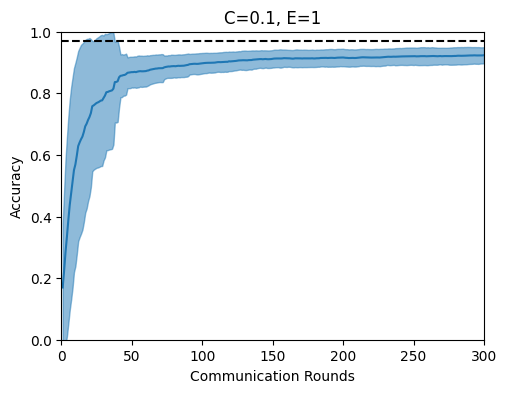

In [ ]:
fl_train(mlp_iid_server, mlp_iid_clients)

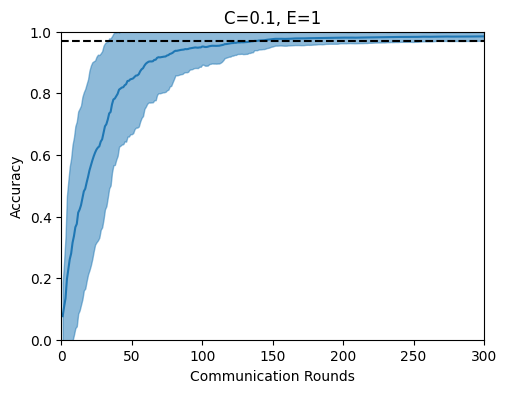

In [ ]:
fl_train(mlp_noniid_server, mlp_noniid_clients)

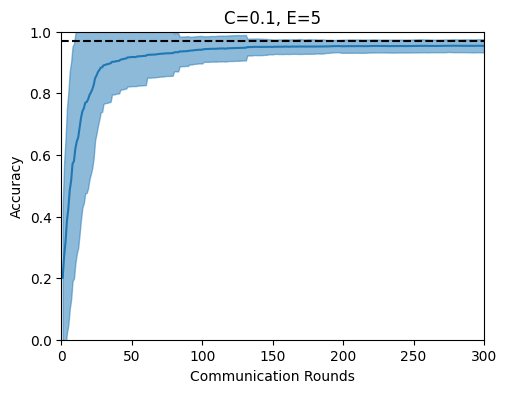

In [ ]:
fl_train(cnn_iid_server, cnn_iid_clients, num_local_epochs=5, max_rounds=300, target_accuracy=0.99)

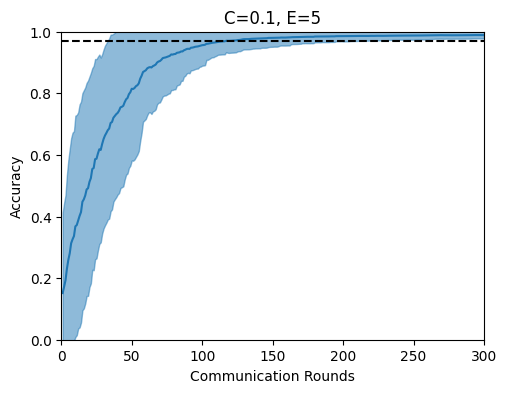

In [ ]:
fl_train(cnn_noniid_server, cnn_noniid_clients, num_local_epochs=5, max_rounds=300, target_accuracy=0.99)